<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 3: Implementing an RAG System for Question Answering

## 0) Install and Import Required Libraries

In [ ]:
#Install Required Packages
!pip install -U langchain langchain-community sentence-transformers faiss-cpu transformers --quiet

#Imports (Grouped by Purpose)
# Core & Utilities
import os
from pathlib import Path
import pandas as pd
import numpy as np
import random
import torch
import faiss
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from langchain_core.documents import Document
import re
#from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


# LangChain Core Components
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# Embeddings & Vector Store
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# LLM: Transformers & Pipeline Wrapping
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from langchain_community.llms import HuggingFacePipeline

# Local Evaluation
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Mount Google Drive (for loading/storing data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Generate and Categorize QA Pairs

This section was created by Rafaella Miranda-Sousa Wasser and Luca Renz

### Load and prepare data

In [ ]:
prepdata_media= pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
prepdata_patent = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")
print("Media Backup:")
prepdata_media.head(5)

Media Backup:


,Unnamed: 0,title,date,author,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,Unknown,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,Unknown,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,Unknown,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch MW float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,Unknown,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,Unknown,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...


In [ ]:
prepdata_patent.head(5)

,publication_number,application_number,title,abstract,publication_date,inventor,processed_text
0,US-2022239235-A1,US-202217717397-A,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,2022-07-28 00:00:00,[],disclose adaptable DC AC inverter system opera...
1,US-2022239251-A1,US-202217580956-A,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",2022-07-28 00:00:00,[],in accordance example embodiment solar energy ...
2,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum steuern einer Windenergieanlage ...
3,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum steuern einer Windenergieanlage ...
4,US-11396827-B2,US-202117606042-A,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,2022-07-26 00:00:00,[],a control method optimize solar power efficien...


### Select 50–100 Relevant Paragraphs

This code filters long, unique paragraphs from media and patent datasets, then exports a selection to CSV for manual review or processing. Later, it loads the refined dataset back in for further use.

In [ ]:
# Function to select long, unique paragraphs
#def get_paragraphs(df, min_words=40, max_paragraphs=50):
#    paragraphs = df["processed_text"].dropna().unique()
#    filtered = [p for p in paragraphs if len(p.split()) >= min_words]
#    return filtered[:max_paragraphs]
#
## Extract paragraphs
#media_paragraphs = get_paragraphs(prepdata_media, max_paragraphs=50)
#patent_paragraphs = get_paragraphs(prepdata_patent, max_paragraphs=50)
#
## Combine and export to CSV for manual processing
#selected_paragraphs = media_paragraphs + patent_paragraphs
#
#pd.DataFrame({'paragraph': selected_paragraphs}).to_csv(
#    "/content/drive/MyDrive/CLT/data/selected_paragraphs.csv", index=False
#)

# Load generated dataset with relevant paragraphs
#selected_data= pd.read_csv("/content/drive/MyDrive/CLT/data/Stage_3/selected_paragraphs.csv")

### Load manually Generate QA Pairs in ChatGPT-4

Based on the selected_data, Q&A pairs were manually created using ChatGPT-4.0, with each question assigned to one of five categories: factual questions, comparative questions, strategic or predictive questions, analytical questions, and technical/process-oriented questions.

In [ ]:
#Load manually Generate QA Pairs in ChatGPT-4
evaluation_data= pd.read_csv("/content/drive/MyDrive/CLT/data/Stage_3/Classified_QA_Pairs_cat.csv")
evaluation_data = evaluation_data.drop('Index', axis=1)
evaluation_data.head(10)

,Paragraph,Question,Answer,Category
0,chinese automotive startup XPeng show one dram...,How has XPeng's vehicle delivery performance e...,XPeng experienced a dramatic increase in vehic...,Factual Questions
1,chinese automotive startup XPeng show one dram...,What infrastructure growth has XPeng achieved ...,XPeng has rapidly expanded its infrastructure ...,Factual Questions
2,chinese automotive startup XPeng show one dram...,How does XPeng's growth compare to other elect...,"While XPeng is not directly compared to Tesla,...",Comparative Questions
3,Sinopec lay plan build large green hydrogen pr...,What is Sinopec's role in the green hydrogen s...,Sinopec is actively entering the green hydroge...,Factual Questions
4,Sinopec lay plan build large green hydrogen pr...,How does Sinopec plan to power its green hydro...,Sinopec's project will be powered by a newly b...,Strategic or Predictive Questions
5,Sinopec lay plan build large green hydrogen pr...,Why is Sinopec’s investment in green hydrogen ...,Sinopec’s investment is significant because it...,Analytical Questions
6,Huaneng Power International switch MW float pv...,What is significant about Huaneng Power Intern...,Huaneng Power International has completed the ...,Factual Questions
7,Huaneng Power International switch MW float pv...,What makes the Qinggang Photovoltaic Power Sta...,"The Qinggang Photovoltaic Power Station, launc...",Factual Questions
8,Huaneng Power International switch MW float pv...,How is Huaneng Power contributing to innovativ...,Huaneng Power is also developing a 2 GW solar ...,Factual Questions
9,accord iranian authority currently renewable e...,What steps is Iran taking to expand its renewa...,"Iran plans to add 10,000 MW of renewable energ...",Factual Questions


## 2) Run RAG Code and Analyze Insights

This section was created by Rafaella Miranda-Sousa Wasser and Luca Renz

### Split Text into Chunks

This section splits long paragraphs into overlapping text chunks to improve retrieval granularity. Each chunk is stored as a document with a reference to its original index.

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
docs = []
for idx, row in evaluation_data.iterrows():
    chunks = splitter.split_text(row["Paragraph"])
    for chunk in chunks:
        docs.append(Document(page_content=chunk, metadata={"source_index": idx}))

### Generate Embeddings and Build FAISS Index

This part encodes the chunks into dense vectors using a SentenceTransformer model and builds a FAISS index for efficient similarity-based retrieval.

In [ ]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
texts = [doc.page_content for doc in docs]
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

### Load QA Model and Define RAG Function

Loads the question-answering model and defines the RAG logic, which retrieves top-k relevant chunks and generates an answer using a custom prompt.

In [ ]:
qa_model = pipeline("text2text-generation", model="google/flan-t5-base", device=0 if torch.cuda.is_available() else -1)

def retrieve_and_answer(query, top_k=3, return_refs=False):
    query_embedding = embedding_model.encode([query])
    _, indices = index.search(query_embedding, top_k)
    retrieved = [texts[i] for i in indices[0]]
    context = "\n".join(retrieved)

    prompt = f"""Answer the question based on the context below:\n\nContext:\n{context}\n\nQuestion: {query}\nAnswer:"""
    response = qa_model(prompt, max_length=256, do_sample=False)
    answer = response[0]['generated_text']
    return (answer, retrieved) if return_refs else answer

Device set to use cuda:0


### Define Evaluation Metrics

Defines three evaluation metrics – semantic similarity to ground truth, relevance of retrieved context to the question, and faithfulness of the answer to the provided context.

In [ ]:
def evaluate_prediction(gt_answer, pred_answer):
    score = util.cos_sim(
        embedding_model.encode(gt_answer, convert_to_tensor=True),
        embedding_model.encode(pred_answer, convert_to_tensor=True)
    )
    return float(score[0][0])

def context_relevance_score(question, context_chunks):
    keywords = re.findall(r'\b\w+\b', question.lower())
    context_text = " ".join(context_chunks).lower()
    matched_keywords = [kw for kw in keywords if kw in context_text]
    return len(matched_keywords) / len(keywords) if keywords else 0.0

def faithfulness_score(answer, context_chunks):
    context_text = " ".join(context_chunks)
    answer_embedding = embedding_model.encode([answer])
    context_embedding = embedding_model.encode([context_text])
    return float(cosine_similarity(answer_embedding, context_embedding)[0][0])

### Run Evaluation Loop

Loops through the dataset, generates predictions using the RAG function, calculates evaluation metrics, and stores all results in a DataFrame.

In [ ]:
results = []
for i, row in evaluation_data.iterrows():
    pred, refs = retrieve_and_answer(row["Question"], return_refs=True)
    sim = evaluate_prediction(row["Answer"], pred)
    ctx = context_relevance_score(row["Question"], refs)
    faith = faithfulness_score(pred, refs)
    results.append({
        "Question": row["Question"],
        "Category": row["Category"],
        "GT_Answer": row["Answer"],
        "Pred_Answer": pred,
        "Semantic_Similarity": sim,
        "Context_Relevance": ctx,
        "Faithfulness": faith
    })

df = pd.DataFrame(results)

In [ ]:
df

,Question,Category,GT_Answer,Pred_Answer,Semantic_Similarity,Context_Relevance,Faithfulness
0,How has XPeng's vehicle delivery performance e...,Factual Questions,XPeng experienced a dramatic increase in vehic...,XPeng reach cumulative delivery all impressive...,0.801531,0.500000,0.883422
1,What infrastructure growth has XPeng achieved ...,Factual Questions,XPeng has rapidly expanded its infrastructure ...,EVs,0.336112,0.307692,0.355151
2,How does XPeng's growth compare to other elect...,Comparative Questions,"While XPeng is not directly compared to Tesla,...",Its production is higher than Tesla's,0.513441,0.538462,0.323746
3,What is Sinopec's role in the green hydrogen s...,Factual Questions,Sinopec is actively entering the green hydroge...,lead player global energy stage seem willing g...,0.308251,0.437500,0.436758
4,How does Sinopec plan to power its green hydro...,Strategic or Predictive Questions,Sinopec's project will be powered by a newly b...,by utilizing renewable energy sources,0.413533,0.437500,0.317319
...,...,...,...,...,...,...,...
220,How does the amino chemical heat pump system c...,Technical/Process-Oriented Questions,The amino chemical heat pump system includes a...,solar collector provide solar energy reaction ...,0.644993,0.571429,0.836285
221,What are the key components that enable solar ...,Factual Questions,The system includes a solar collector to provi...,solar cell,0.500231,0.307692,0.497493
222,What is the purpose of the first arc-shaped gr...,Factual Questions,The first arc-shaped groove is designed to dif...,enable solar energy irradiate first arc shape ...,0.575558,0.687500,0.981418
223,How does the solar cell module system minimize...,Factual Questions,The system minimizes energy loss by incorporat...,It is decentralized,0.087025,0.400000,0.209358


### Summary Statistics and Visualization

Aggregates performance metrics by question category and visualizes answer similarity across categories using a boxplot.

Average rating by category:
                               Category  Semantic_Similarity  \
0                  Analytical Questions             0.472509   
1                 Comparative Questions             0.584421   
2                     Factual Questions             0.442042   
3     Strategic or Predictive Questions             0.526665   
4  Technical/Process-Oriented Questions             0.357692   

   Context_Relevance  Faithfulness  
0           0.494668      0.441580  
1           0.400240      0.461843  
2           0.503551      0.483037  
3           0.471942      0.556585  
4           0.512075      0.431196  


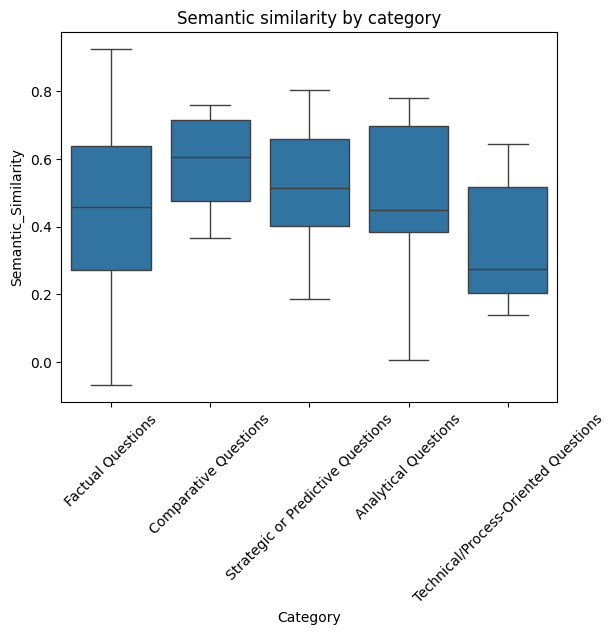

In [ ]:
summary = df.groupby("Category")[["Semantic_Similarity", "Context_Relevance", "Faithfulness"]].mean().reset_index()

print("Average rating by category:")
print(summary)

sns.boxplot(data=df, x="Category", y="Semantic_Similarity")
plt.xticks(rotation=45)
plt.title("Semantic similarity by category")
plt.show()

The chart and accompanying metrics provide a comparative evaluation of the semantic similarity scores across different question categories in the cleantech domain. Overall, Comparative Questions achieved the highest average semantic similarity score (0.584421), indicating that the RAG system performs particularly well when comparing technologies or scenarios. Strategic or Predictive Questions also showed strong performance (0.526665), with the highest faithfulness score (0.556585), suggesting the model is able to generate forward-looking insights while staying grounded in retrieved context.

In contrast, Technical/Process-Oriented Questions performed worst across all metrics, especially in semantic similarity (0.357692) and faithfulness (0.431196), highlighting a challenge in retrieving or generating accurate technical explanations. Factual Questions displayed a wide variance in performance, as seen in the boxplot, implying that while some answers are highly relevant, others are disconnected, possibly due to lack of precise context retrieval.

This analysis suggests that the RAG system is most effective in handling high-level comparative or strategic queries, but struggles with technically detailed or procedural content. These findings point to potential improvements in context retrieval mechanisms or domain-specific finetuning for better handling of technical cleantech data.

## 3) Enhance RAG System

This section was created by Alvaro Cervan and Luca Renz

## 4) Testing in RAG Playground (Optional)

This section was created by